In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import os
from itertools import product
import re
import random
import numpy as np

In [2]:
def neighbor_edges_of_node(graph, node):
    return [edge for edge in graph.edges() if node in edge]

In [3]:
def is_valid_coloring(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    
    for edge in graph.edges():
        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                return False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                return False
    return True

In [4]:
def read_graph_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        num_nodes, num_edges = map(int, lines[0].split()[2:])  # extractiong num_nodes and num_edges
        edges = [tuple(map(int, line.split()[1:])) for line in lines[1:] if line.startswith('e')]
        graph = nx.Graph()
        graph.add_nodes_from(range(1, num_nodes + 1))
        graph.add_edges_from(edges)
        
        return graph
    

In [5]:
def draw_colored_graph(graph, coloring):    
    nx.draw(graph, with_labels=True, edge_color=coloring)
    plt.show()

In [6]:
def write_output(graph, test_name, coloring_result, iter, start_time, end_time):

    print(coloring_result)
    with open('./results/aco_results.txt', 'a') as result_file:
        result_file.write(f"Test Name: {test_name}\n")
        result_file.write("Result: ")
        
        
        if len(coloring_result) == 1 and coloring_result[0] == -100:
            result_file.write("No solution found.\n")
            print("No solution found.\n")
        
        else:
            result_file.write("Minimum edge coloring found.\n")
            result_file.write(f"Number of colors: {len(set(coloring_result))}\n")
            result_file.write(f"Number of iterations: {iter}\n")

            print("Minimum edge coloring found.")
            print("Number of colors:", len(set(coloring_result)))  
            print("Number of iterations:", iter)
            draw_colored_graph(graph, coloring_result)
            plt.close() 
             

        time_taken = end_time - start_time

        result_file.write(f"Time taken (seconds): {time_taken}\n")
        print("Time taken:", time_taken, "seconds\n")    
        result_file.write("\n")

In [7]:
def numerical_sort(value):
    parts = re.split(r'(\d+)', value)
    parts = [int(part) if part.isdigit() else part for part in parts]
    return parts

In [8]:
import numpy as np

def calculate_conflicts(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    num = 0

    for edge in graph.edges():
        indicator = True

        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                indicator = False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                indicator = False

        if indicator:
            num += 1
    
    return len(graph.edges()) - num

def ant_colony_optimization(graph, num_ants, num_iterations, alpha, beta, evaporation_rate, pheromone_deposit):
    num_nodes = len(graph.nodes())
    num_edges = len(graph.edges())
    num_colors = num_edges  # Initially set the number of colors to the number of nodes
    
    # Initialize pheromone matrix with small random values
    pheromone_matrix = np.random.rand(num_edges, num_colors)
    
    # Initialize best coloring and its value
    best_coloring = np.zeros(num_edges, dtype=int)
    best_value = float('inf')
    
    for iteration in range(num_iterations):
        # Initialize ant solutions
        ant_solutions = np.zeros((num_ants, num_edges), dtype=int)
        
        # Construct ant solutions
        for ant in range(num_ants):
            for edge in range(num_edges):
                probabilities = np.zeros(num_colors)
                if graph.has_node(edge):  # Check if edge is a valid node
                    for color in range(num_colors):
                        probabilities[color] = (pheromone_matrix[edge][color] ** alpha) * ((1 / (graph.degree(edge) + 1)) ** beta)
                    
                sum_probabilities = np.sum(probabilities)
                if sum_probabilities == 0:
                    probabilities = np.ones_like(probabilities) / len(probabilities)
                else:
                    probabilities /= sum_probabilities
                ant_solutions[ant][edge] = np.random.choice(range(num_colors), p=probabilities)
        
        # Update pheromone matrix locally
        for ant in range(num_ants):
            value = calculate_conflicts(graph, ant_solutions[ant])
            if value < best_value:
                best_value = value
                best_coloring = ant_solutions[ant]
                for edge in range(num_edges):
                    pheromone_matrix[edge][ant_solutions[ant][edge]] += pheromone_deposit
        
        # Global update of pheromone matrix
        pheromone_matrix *= (1 - evaporation_rate)
        for edge in range(num_edges):
            for color in range(num_colors):
                if color == best_coloring[edge]:
                    pheromone_matrix[edge][color] += pheromone_deposit / (best_value + 1e-10)

    # Update number of colors if a better coloring is found
        if value < best_value  and is_valid_coloring(graph, ant_solutions[ant]):
            best_coloring = ant_solutions[ant]
    
    return best_coloring, best_value, len(np.unique(best_coloring))

In [9]:
def run_tests(directory):
    files = os.listdir(directory)
    sorted_files = sorted(files, key=numerical_sort)

    num_ants = 10
    num_iterations = 100 
    
    alpha = 1
    beta = 1
    evaporation_rate = 0.2
    pheromone_deposit = 1
    
    for file in sorted_files:
        if file.endswith('.txt'):
            filepath = os.path.join(directory, file)
            print(f"Running test {file}...")

            start_time = time.time()
            graph = read_graph_from_file(filepath)
            best_coloring, best_value, num_colors = ant_colony_optimization(graph, num_ants, num_iterations, alpha, beta, evaporation_rate, pheromone_deposit)
            end_time = time.time()
            print("Best Coloring:", best_coloring)
            print("Best Value:", best_value)
            print("Number of Colors:", num_colors)
            write_output(graph, file, best_coloring, num_colors, start_time, end_time)

Running test graph_101_edges.txt...
Best Coloring: [ 51  74  33  18  25  46  36  30   9  24  77  13  88  81  21   8  76  63
  99  84   4  47  30  75  74  22  67  92  26  83  84  43  82  92  89   5
  14 100  13  36   1  77  61  37  57  99  60  95  92   7  62  75  78  19
  79  57  43  31  13  65  63  44  19  78  94  51  86  95  72  35  64  31
  56  62   2  34  78  14  72  23  20  12  46  58  82   7  91  59  48  76
  71  52  73  16  91  54  86  34  17  28   0]
Best Value: 4
Number of Colors: 71
[ 51  74  33  18  25  46  36  30   9  24  77  13  88  81  21   8  76  63
  99  84   4  47  30  75  74  22  67  92  26  83  84  43  82  92  89   5
  14 100  13  36   1  77  61  37  57  99  60  95  92   7  62  75  78  19
  79  57  43  31  13  65  63  44  19  78  94  51  86  95  72  35  64  31
  56  62   2  34  78  14  72  23  20  12  46  58  82   7  91  59  48  76
  71  52  73  16  91  54  86  34  17  28   0]
Minimum edge coloring found.
Number of colors: 71
Number of iterations: 71


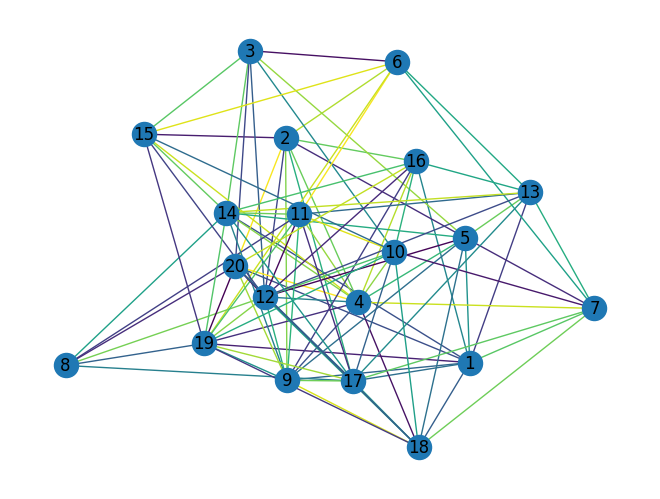

Time taken: 41.44307065010071 seconds

Running test graph_121_edges.txt...
Best Coloring: [ 28  85  26  97  65  77  94  61  87 108  73  85   6  43  90  39   8  67
 115   7  78  60 102  75  59 119  50  50  95 107 114  17 120 116  30  12
  70  87  61  94  65  81  41  47  31  80  11  63   0  10  42  93 100  86
  36  53 119   2  56  57  25  23  14  59  82  30  60  42  22  35  98  85
 119  19  78  32 105  16  34  68  25  55  43  31  69  46  96  18  82 105
  38  27  10  43  44  15   0  60  83   9  94  25  15  65  86  19  51  97
  83  44  21  53 106  78  80  87  54  60  69   3 108]
Best Value: 4
Number of Colors: 82
[ 28  85  26  97  65  77  94  61  87 108  73  85   6  43  90  39   8  67
 115   7  78  60 102  75  59 119  50  50  95 107 114  17 120 116  30  12
  70  87  61  94  65  81  41  47  31  80  11  63   0  10  42  93 100  86
  36  53 119   2  56  57  25  23  14  59  82  30  60  42  22  35  98  85
 119  19  78  32 105  16  34  68  25  55  43  31  69  46  96  18  82 105
  38  27  10  43  

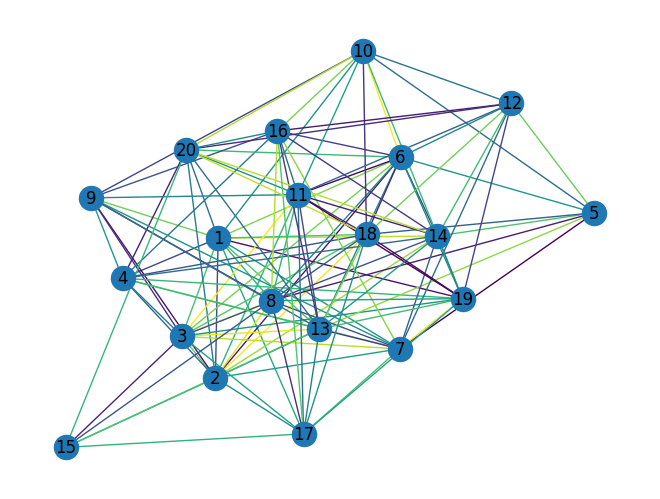

Time taken: 52.40081167221069 seconds

Running test graph_140_edges.txt...
Best Coloring: [ 64 111 116  93 131  59  91  31 111 124  44 106  52  63  37   0  15 118
 123  18  83 101  24  25 100 136  45  53  85  44  99   5  18  98 117  22
  51  83  43   2  55  35   1  43  18  54  51  28   9  25  44  97 134  18
 102  92  41  84  56 118  47  45  65 135  39  61  53  96 107  73  95  28
  97   6  73  76 132  33 101  71  20  77  92 135 105 113  27 102  58  37
 109 136 137  95  26  30  47  33  73 137  49 100 118  52  73  48   2  64
  55 126 127  72  47 126 113  68  10  80 129 105   6   7  64 106 133 105
  17 125 126  27 131  37  36  84 103  83 134  46   2  63]
Best Value: 6
Number of Colors: 89
[ 64 111 116  93 131  59  91  31 111 124  44 106  52  63  37   0  15 118
 123  18  83 101  24  25 100 136  45  53  85  44  99   5  18  98 117  22
  51  83  43   2  55  35   1  43  18  54  51  28   9  25  44  97 134  18
 102  92  41  84  56 118  47  45  65 135  39  61  53  96 107  73  95  28
  97   6  73  

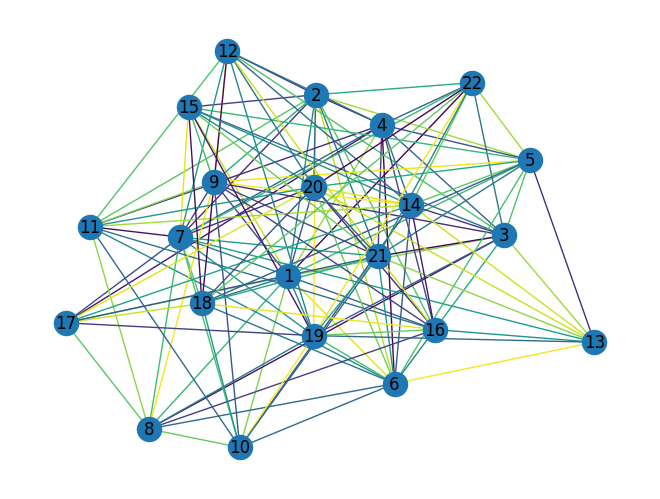

Time taken: 64.04513692855835 seconds

Running test graph_156_edges.txt...
Best Coloring: [ 89  22  57  38 106  20  82   0 121  35 153  59  88 128  72  14  93  27
  86  29   4  44  95 148 106  12   2  28  67 105  20   9  70  65  53 100
  84 133 101   9  24 125  61  41 126 151  74  87 118 120  34 102  49  69
  85  97 103 129  46  94  29  55  99 121  20   0 140  18 136  54 108 119
  33 112  38  15  26   9  45 137  41 153 124  57  11  33  23  75  71 130
  62 126  13 148 128 117 125  69   8  68  50  59  53  42  68  33  62 105
  18 132   7  58 152  13  64  52  77  23 149  66  20 143  26  93 129 102
 107  33 126 113 115 123 127 155 135  33 118  16  51 101   5   2 134   8
  11 131  64  63  34 146  51  31  21 125 142  50]
Best Value: 8
Number of Colors: 111
[ 89  22  57  38 106  20  82   0 121  35 153  59  88 128  72  14  93  27
  86  29   4  44  95 148 106  12   2  28  67 105  20   9  70  65  53 100
  84 133 101   9  24 125  61  41 126 151  74  87 118 120  34 102  49  69
  85  97 103 129  46 

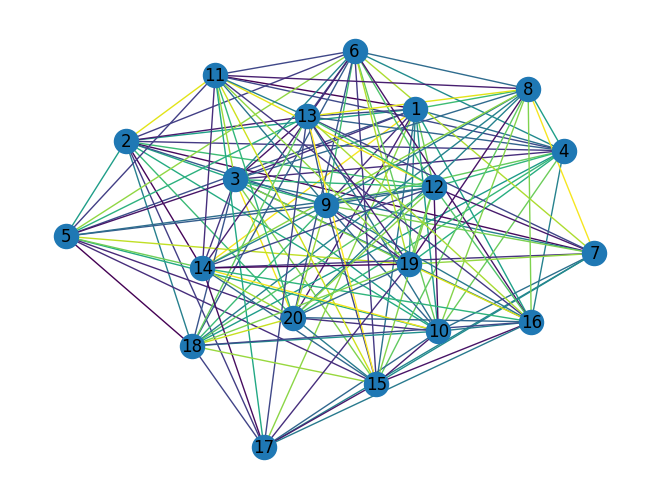

Time taken: 67.37170648574829 seconds

Running test graph_165_edges.txt...
Best Coloring: [123  37   7  87  91 107  76  17 146  67 127  69 120  90 140 160  13 130
 103 135 114  40  89  98  40 122   0  39  33  82  21  18  11  89  29 138
  87   4 151 158  13   3 105  78  49  87 133 129 159  86 148  63  18 126
  12 137  46  67  54  68  80 100 108 121  55  50  26 129  26  52   1   3
  77  94  85   0 146  21 133  14  63  48 151  11  65  47 119  36  89  23
 136  35 152  66  90 107 157  88 100 122 133 131 101 133 108  13  95  19
  38  23 145  39   1  21  94  46 103  41  40  77 162   8 149 148 150 120
  14  82 127 134 102  63  63  54  47  15  90  11  95 123  71  45  65 125
 163  48  30 157 115  79  25 144  74 145 155 151 135 112  97 115  57 145
  96 150 117]
Best Value: 6
Number of Colors: 108
[123  37   7  87  91 107  76  17 146  67 127  69 120  90 140 160  13 130
 103 135 114  40  89  98  40 122   0  39  33  82  21  18  11  89  29 138
  87   4 151 158  13   3 105  78  49  87 133 129 159  86 

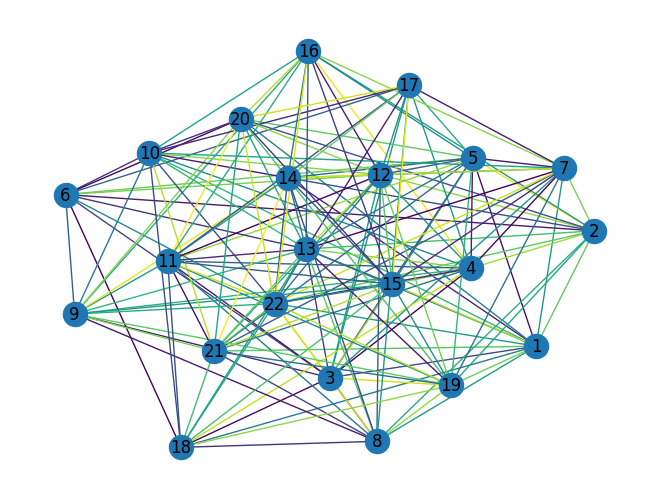

Time taken: 77.7109386920929 seconds

Running test graph_177_edges.txt...
Best Coloring: [ 69 110  19  55 168 160  29 113 144 162  99  92 135   4 150  29 140   1
  13  24   7   0 151 152   6   7  36  70  62  63  43  54 124  68  17  73
 160 118 132 122 154  29   8 151  66  59  16 122  47 150 147  36  37  20
 157 166  16  85  94  31  73  47 103  23  44 144 143 100  45  54  77  63
   1  49 145 109 154 151 159 149  88 120  64  35 141  69 125 117  14 132
 144  36 110 135 170  90 155 157 104  97  85  20 139  38 116 137  27 138
  44 153 113  90  57   8  85  77  89 119 169 135 143 113  75 101  16  25
  45 148 135  32 131  97 116  54 150 151 108 154 109  89  65   9  91  91
  33  96  89  94 116 134  57 153  51 129  76  33  41  95  46  44 114 174
  49  22  31 123  30 133  32 136 160  24  25  60 121 137 104]
Best Value: 12
Number of Colors: 115
[ 69 110  19  55 168 160  29 113 144 162  99  92 135   4 150  29 140   1
  13  24   7   0 151 152   6   7  36  70  62  63  43  54 124  68  17  73
 160 118 

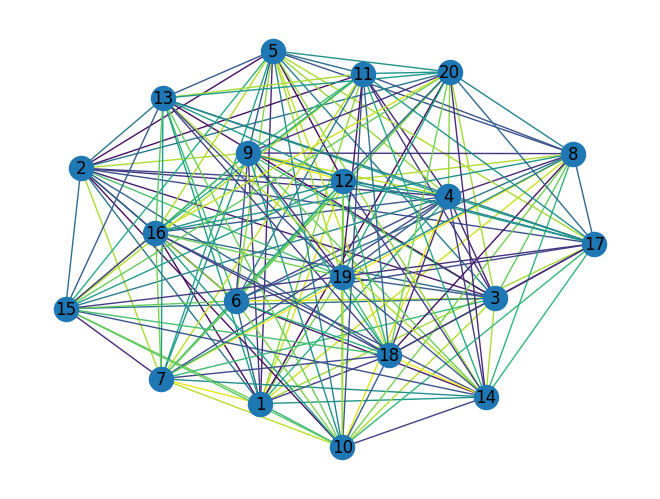

Time taken: 78.71510934829712 seconds

Running test graph_204_edges.txt...
Best Coloring: [193 121  19  26  55  39  63 151 104  96 153 202  30  28 121  56 141 190
  35 167  82 197  73  47 176 185 173  17  21  97 170 132 123  44  18  12
  79  90  66  14 167 174 112  27  25 168 155 186  33 166  97 191  24 192
  84  75  27 184 159   1  72 173  39 201 130 177  23  71   6  64  24  84
 141 106 147  90  66 146  51  67 193 122 200 111 124  17 153  50  52  17
 103  60 126 170 169 200 135  71 100 186  50  85 170 168 166  45 155 108
  69 147  78   3  39 172 131  43 144 190 113 101 113  99  45 164 149   4
 187  16  63  52  68 203  17  28  50  72  40  15 158 107 200 177 147 179
  70  19  73  78 188  74 100 104 154 119 179 146 107  11  91 116 100 109
  24  55 156 195  15 173  44 178 128  89 101 136 131 127  19 115  38 171
 192 103  26 129  20 137  88  44   0 188   2  75 124 136 198 100 144  48
  50 116 131  40  77 134]
Best Value: 13
Number of Colors: 135
[193 121  19  26  55  39  63 151 104  96 153

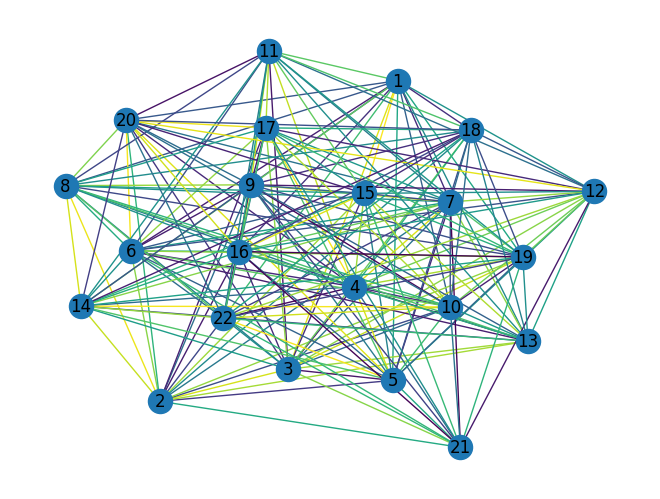

Time taken: 113.58929085731506 seconds

Running test graph_227_edges.txt...
Best Coloring: [185 103  56 218  14   9   7 156 130  65 142  17 157 107 188 199  77 134
 145 140 122 158 116 100 113 120   7 202  59 199 157 127 224  61 196 170
 198 112  69 206 100 127   2 146 160  63  35  72  64 208 222  81  89 150
 159 128  87  38 115 161 195 136 153 139  17 187 165  82  99 184 159 180
  72 223 190 153 173  55 158 161 220 137 130 103 198  60  97   8 122  67
  50 216 144  71  50  70  89 200  56 104 179 158  93 144  64  67 113 162
  15 149  91  63 203  18 144  56  16 104  85  16 214 119 225 116 136 107
  68  78 138   8  79 112 117 217  83 196 106 180  56  78 224  88 210  54
 161 142  45 182 112  43 195  16 199 154 176 193 220  82 154  96 106 195
 202  57 132  71  69 196 191 220 155  55  32 154 201  23   9  62 151 219
  88 172  70  38 173 118  89  97 136  15 142 144  36 186   4 139  77  52
 195 187   4  13  90 212  60 172  39 120 217 101  67  18 108 206 148  96
 115 193  47  20 157  91 169 119 

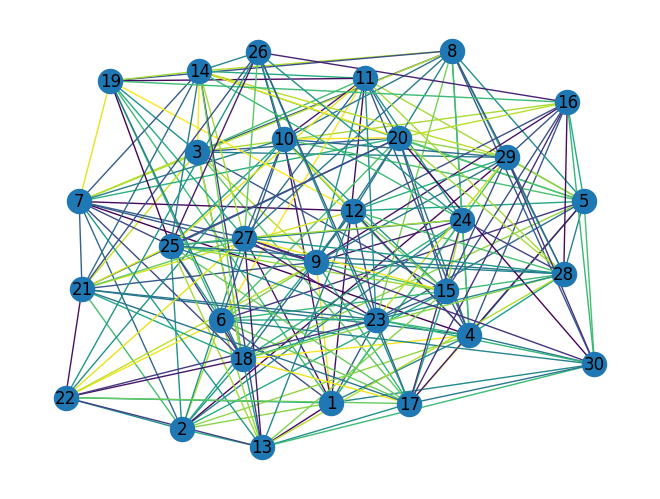

Time taken: 75.80224132537842 seconds

Running test graph_273_edges.txt...
Best Coloring: [ 52 196 242 156 211 208 181 199 118  29  27 240 108  79   1 164  80  69
  62 164 155 183 241  53  38  23  12 146 213 269  46 119 223   4  92 270
 247 238 227 255  62   7 193 145 252 100 257 104 197   4 158 163 138 226
 144  69  31 269  71  94  67 262 186  88 221   8 246 259 170 154 215 233
 216 207  12 142  34 164 156  54  49 110  11  97 262 173  42 159 101 181
 125 136 113 193 194  47 227  43 114  11 122 227 194  90 137  65  81 208
   2  76 133  33 205 178 201  35 116 103 187 138 170 252  89  42  58 223
 212 151 101   3 143  74 197 102  17 208 259 201 204 161 243 222  91  55
 269 179  11 230 226   0 162   1 225 235  77 244  27 189 110 180  31 127
  29 200  43 143 214  46 151 167 208  92 223  32 105 110 128 154 113 262
 157 224 132 121 118  98 207 147 211 205  61  50 148   9  34 210  85  63
 233 110 238 118 217 128 191   3 186 267 124   5 155 168 269 254  26 197
 240 113 230 218  30  12 185  18 2

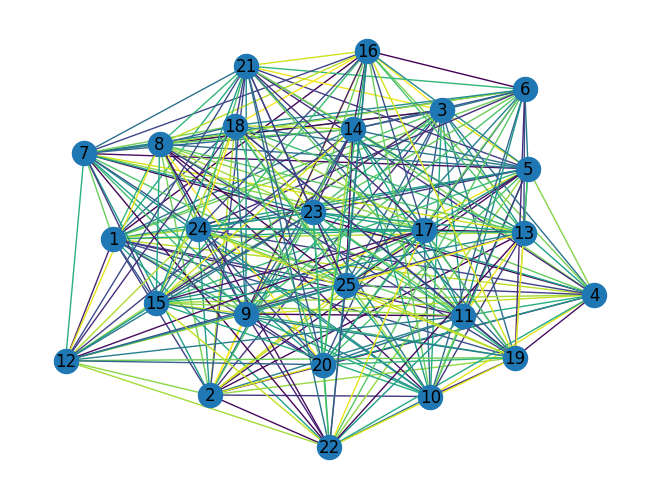

Time taken: 88.25903987884521 seconds

Running test graph_275_edges.txt...
Best Coloring: [ 73 230 185 191  84 234  98  32   1 235  66  38 269 260  99 115 261  88
 133 231 122  62  35 108  24 144 227 143 106  28 207  15 124 187  63 121
  19 160 171  30 176  59  87  14 270 142 139 215  59 109  36 178 131  36
 237  37 196 137 230  53 239 118  70  82 155 161  38 115  40 150  85 185
 127 272 260 198   9 178  92  74  33 190 129 186 258 101  96  46 213 122
 112 180 251  19 115  40  56 118 235 135 185 215 239 105 233  87 134 223
 262 161 141  60 100  85 132 213 202 111 135 201 272 142  38 139 218 251
 118 161  46  41  29  49 206 208 172  85  20 135 186 150 227 111 241  27
 191  73  68  31 204  90  63 231  49  39  65 217 216 136 165 258  21  95
 175 141 239  95 146 244  30  85 123   5 264  51 128 254 106 218 118 117
 197 173 161  68 267  43  55  45  12 170  33 227  40  51 184 248 265  48
  50  78 124 254  80  67  54   7  68 243 253   5 147  22 113 245 103  81
  26 264 174 133 269  52  32  55  

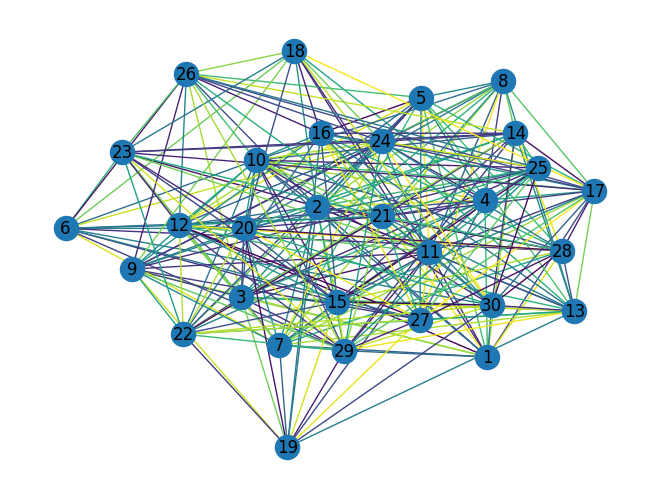

Time taken: 93.70205879211426 seconds



In [10]:
with open('./results/aco_results.txt', 'w') as result_file:
    result_file.write("")

run_tests('./tests')